In [1]:
import pylab as plt
import numpy as np
import pandas as pd
import proposal as pp  #installed with pip
import scipy
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import re
import sys
import glob
#from MCEq.core import config, MCEqRun
#import crflux.models as crf
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import random
try:
    import cPickle as pickle
except ImportError:
    import pickle
from scipy.interpolate import interp2d, NearestNDInterpolator,LinearNDInterpolator




In [3]:
def get_color(n, colormax, cmap="PiYG"):
    
    this_cmap = plt.get_cmap(cmap)
    return this_cmap(n/colormax)

CLRS=["gray","firebrick","orchid","deepskyblue","orange","blueviolet","magenta","limegreen","pink","tomato","red","black","yellow","darkgreen"]

energies=[100,300,400,450,500,550,600,650,700,800,900,1000,2000,4000,6000]
GeV=1000

NumToRun=1000

AreaOfNextNEW=np.pi*(45/2)**2*66 #cm^2 but these dimensions need double checked

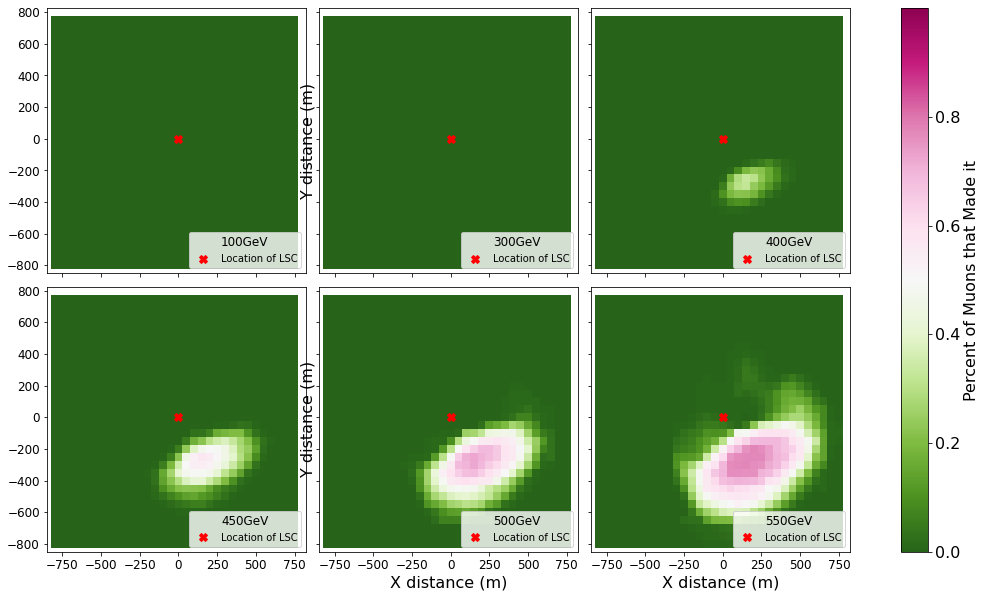

In [5]:
a=0

#locs=[3]
locs=[0,1,2,3,4,5,6]


spacing=50
NumToRun=1000
Xmin=-600-spacing
Xmax=600+spacing/2
Ymin=-600-spacing
Ymax=600+spacing/2

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(18,10), sharex=True, sharey=True)
cmap = plt.get_cmap('PiYG')
for ax in axes.flat:
    LOC=locs[a]
    


    NRG=energies[LOC]

    with open('./NewInterps/Proposal_Muons_Interpolator'+str(NRG)+'.0GeV.pkl', 'rb') as f:
        PercentMuons = pickle.load(f)

    intexs=[]
    inteys=[]
    intepercs=[]
    
    spacing=50
    NumToRun=1000
    Xmin=-800-spacing
    Xmax=800+spacing/2
    Ymin=-800-spacing
    Ymax=800+spacing/2
    for X in range(-800,800,spacing):
        for Y in range(-800,800,spacing):
            intexs.append(X)
            inteys.append(Y)
            intepercs.append(PercentMuons(X,Y))


    intepercs = np.array(intepercs)
    intepercs=intepercs.reshape(len(np.unique(intexs)), len(np.unique(inteys)))
            
    
    im=ax.pcolormesh(np.unique(intexs),np.unique(inteys),np.transpose(intepercs),cmap=cmap.reversed(),shading='auto',vmin=0, vmax=1)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlim(Xmin,Xmax)
    ax.tick_params(axis='both', which='major', labelsize=12)


    #ax.title("Energy ="+str(energies[LOC]*GeV/10**6)+"TeV")
    ax.plot([0],[0],'X',label='Location of LSC',color='red',markersize=8)
    ax.legend(loc='lower right',title=str(NRG)+'GeV',title_fontsize=12)
    

    if (LOC>3):
        ax.set_xlabel("X distance (m)",fontsize=16)
    if (LOC==1) or (LOC==4):        
        ax.set_ylabel("Y distance (m)",fontsize=16)
    a+=1
fig.subplots_adjust(wspace=.05, hspace=.05)

cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Percent of Muons that Made it')
cbar.set_ticks(np.arange(0, 1, 0.2))
cbar.set_label('Percent of Muons that Made it', fontsize=16)
cbar.ax.tick_params(labelsize=16)
#fig.clim(0,1)


#fig.savefig("/Users/rogerslc/PROPOSAL/PROPOSAL/SimulatedPercents.png",dpi=250,bbox_inches='tight')

#plt.show()






In [165]:
#to read file
f=open("../CanfrancMountainProfile/ExtendedMountain.pkl",'rb')
mountain=pickle.load(f)
StepSize=10
eps=0.1   # This is a trick to stop divide by zero errors

m_to_cm=100
GeV=1000

#putting coordinates in format for contour plot
Ymax=600
Xmax=600
Ymin=-600
Xmin=-600



vals=[]
X1= np.arange(Xmin,Xmax, StepSize)
Y1= np.arange(Ymin,Ymax, StepSize)
for ys in Y1:
    for xs in X1:   
        vals.append(mountain(xs,ys))

vals = np.array(vals)

zz=vals.reshape(len(Y1), len(X1))
[xx,yy]=np.meshgrid(np.arange(Xmin,Xmax,StepSize),np.arange(Ymin,Ymax,StepSize))

#Find the thetas and phis and distance through rock for each grid square
phioffset=0                      # Orientation of detector relative to map - you need to figure this out.
rho=((xx+eps)**2+(yy+eps)**2)**0.5             # cylindrical rho coordinate
theta=np.arctan(rho/(zz+eps))           # spherical theta coordinate (0 = downgoing)
phi = np.arctan2((yy+eps),(xx+eps)) + phioffset # spherical phi coordinate
distancetodetector = np.sqrt((zz+eps)**2+(xx+eps)**2+(yy+eps)**2)

# continuously interpolate rock length and depth functions so we can sample at any X,Y
depth     =lambda x,y:  mountain(x,y)
rocklength=lambda x,y:  (x**2+y**2+mountain(x,y)**2)**0.5

def GetMuonInfo(startMuon):
    depthMuon   = np.round(depth(*startMuon),2)
    distMuon    = np.round(rocklength(*startMuon),2)
    thMuon      = np.round(np.arctan((startMuon[0]**2+startMuon[1]**2)**0.5/depthMuon),2)
    phiMuon     = np.round(np.arctan2(startMuon[1],startMuon[0]),2)
    return thMuon,phiMuon,depthMuon,distMuon



In [167]:
GetMuonInfo([100,500])

(0.7, 1.37, 611.18, 795.96)

In [168]:
costhetas=[]
phis=[]
survfrac=[]
xs_lim=[]
ys_lim=[]
for i in range(0,len(intexs)):
    x=np.array(intexs).flatten()[i]
    y=np.array(inteys).flatten()[i]
    c=np.array(intepercs).flatten()[i]
    startMuon = (x,y)
    thMuon,phiMuon,depthMuon,distMuon=GetMuonInfo(startMuon)
    if(np.cos(thMuon)>0.4):
        xs_lim.append(x)
        ys_lim.append(y)
        survfrac.append(c)
        costhetas.append(np.cos(thMuon))
        phis.append(phiMuon)
maxcol=max(np.array(survfrac).flatten())

Text(0, 0.5, 'cos$\\alpha$')

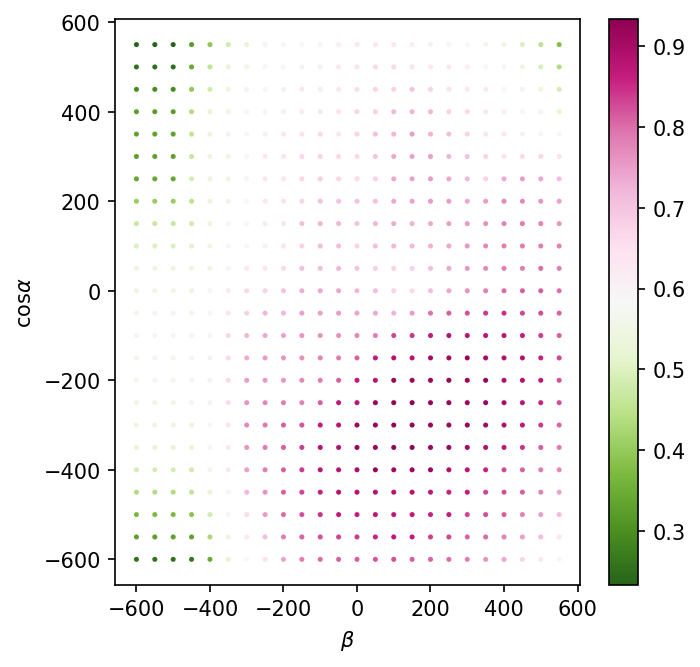

In [169]:
plt.figure(figsize=(5,5),dpi=150)
plt.scatter(np.array(intexs).flatten(),np.array(inteys).flatten(),c=(np.array(intepercs).flatten()),s=2,cmap = plt.get_cmap('PiYG').reversed())
plt.colorbar()
plt.xlabel(r"$\beta$")
plt.ylabel(r"cos$\alpha$")
#plt.ylim(0,1)
#plt.plot([-np.pi,np.pi],[0.4,0.4],color='red')
#plt.xlim(-np.pi,np.pi)

In [89]:
len(xs_lim)

465

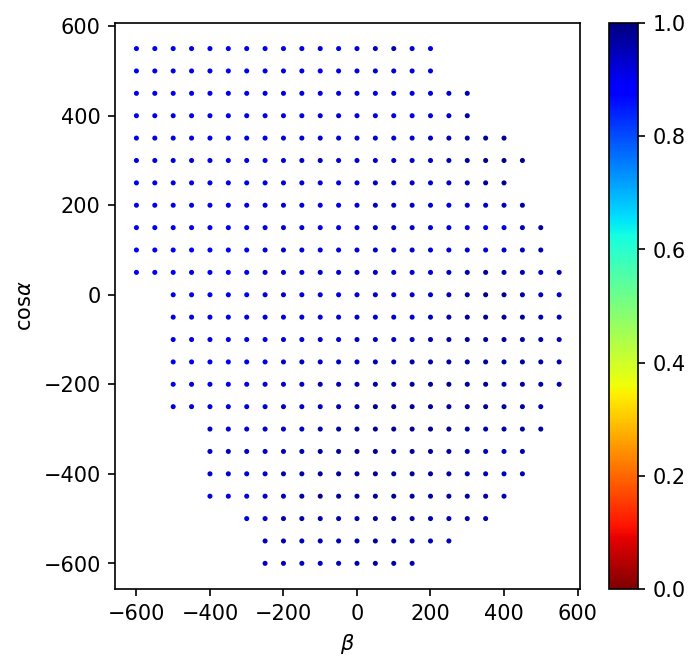

In [90]:
plt.figure(figsize=(5,5),dpi=150)
plt.scatter(xs_lim,ys_lim,c=survfrac,s=2,cmap = plt.get_cmap('jet').reversed())
plt.colorbar()
plt.xlabel(r"$\beta$")
plt.ylabel(r"cos$\alpha$")
plt.clim(0,1)
#plt.ylim(0,1)
#plt.plot([-np.pi,np.pi],[0.4,0.4],color='red')
#plt.xlim(-np.pi,np.pi)

In [91]:
phis

[3.06,
 2.98,
 2.9,
 2.82,
 2.75,
 2.68,
 2.61,
 2.55,
 2.5,
 2.45,
 2.4,
 3.05,
 2.96,
 2.88,
 2.79,
 2.71,
 2.64,
 2.57,
 2.51,
 2.46,
 2.4,
 2.36,
 -2.68,
 -2.76,
 -2.85,
 -2.94,
 -3.04,
 3.14,
 3.04,
 2.94,
 2.85,
 2.76,
 2.68,
 2.6,
 2.53,
 2.47,
 2.41,
 2.36,
 2.31,
 -2.63,
 -2.72,
 -2.82,
 -2.92,
 -3.03,
 3.14,
 3.03,
 2.92,
 2.82,
 2.72,
 2.63,
 2.55,
 2.48,
 2.41,
 2.36,
 2.3,
 2.26,
 -2.3,
 -2.36,
 -2.42,
 -2.5,
 -2.58,
 -2.68,
 -2.78,
 -2.9,
 -3.02,
 3.14,
 3.02,
 2.9,
 2.78,
 2.68,
 2.58,
 2.5,
 2.42,
 2.36,
 2.3,
 2.25,
 2.2,
 -2.23,
 -2.29,
 -2.36,
 -2.43,
 -2.52,
 -2.62,
 -2.74,
 -2.86,
 -3.0,
 3.14,
 3.0,
 2.86,
 2.74,
 2.62,
 2.52,
 2.43,
 2.36,
 2.29,
 2.23,
 2.18,
 2.14,
 -2.11,
 -2.16,
 -2.21,
 -2.28,
 -2.36,
 -2.45,
 -2.55,
 -2.68,
 -2.82,
 -2.98,
 3.14,
 2.98,
 2.82,
 2.68,
 2.55,
 2.45,
 2.36,
 2.28,
 2.21,
 2.16,
 2.11,
 2.07,
 -1.97,
 -2.0,
 -2.03,
 -2.08,
 -2.13,
 -2.19,
 -2.27,
 -2.36,
 -2.47,
 -2.6,
 -2.76,
 -2.94,
 3.14,
 2.94,
 2.76,
 2.6,
 2.47,
 2.36,
 2

(-3.141592653589793, 3.141592653589793)

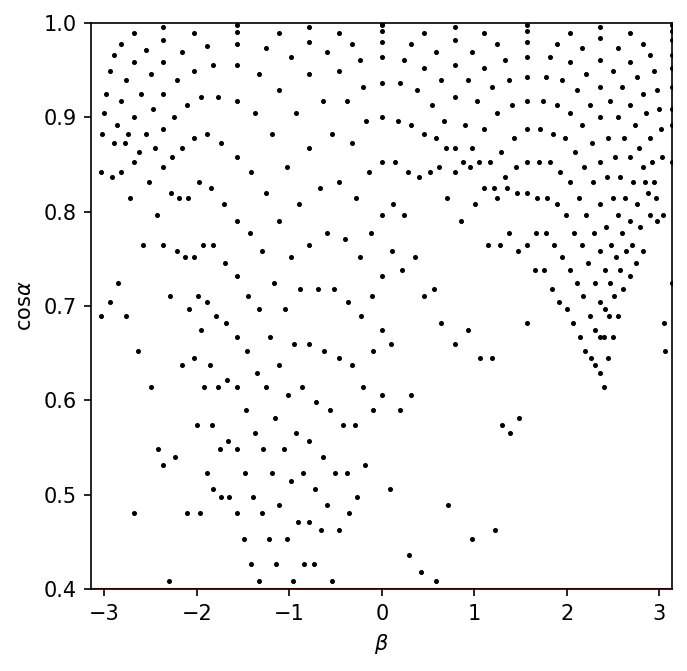

In [92]:
plt.figure(figsize=(5,5),dpi=150)
plt.scatter(phis,costhetas,s=2,c='black')
#plt.colorbar()
#plt.clim(0,1)
plt.xlabel(r"$\beta$")
plt.ylabel(r"cos$\alpha$")
plt.ylim(0.4,1)
plt.plot([-np.pi,np.pi],[0.4,0.4],color='red')
plt.xlim(-np.pi,np.pi)

In [170]:
cosa_sample=np.linspace(0.4,1,50)
a_sample=np.arccos(cosa_sample)
b_sample=np.linspace(-np.pi,np.pi,100)
cosa_mesh,b_mesh=np.meshgrid(cosa_sample,b_sample)

In [171]:
from matplotlib import colors, cm

In [172]:
maxcol

0.9339999999999997

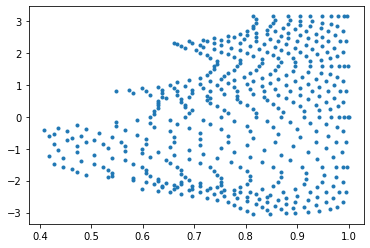

In [173]:
plt.plot(costhetas,phis,'.')

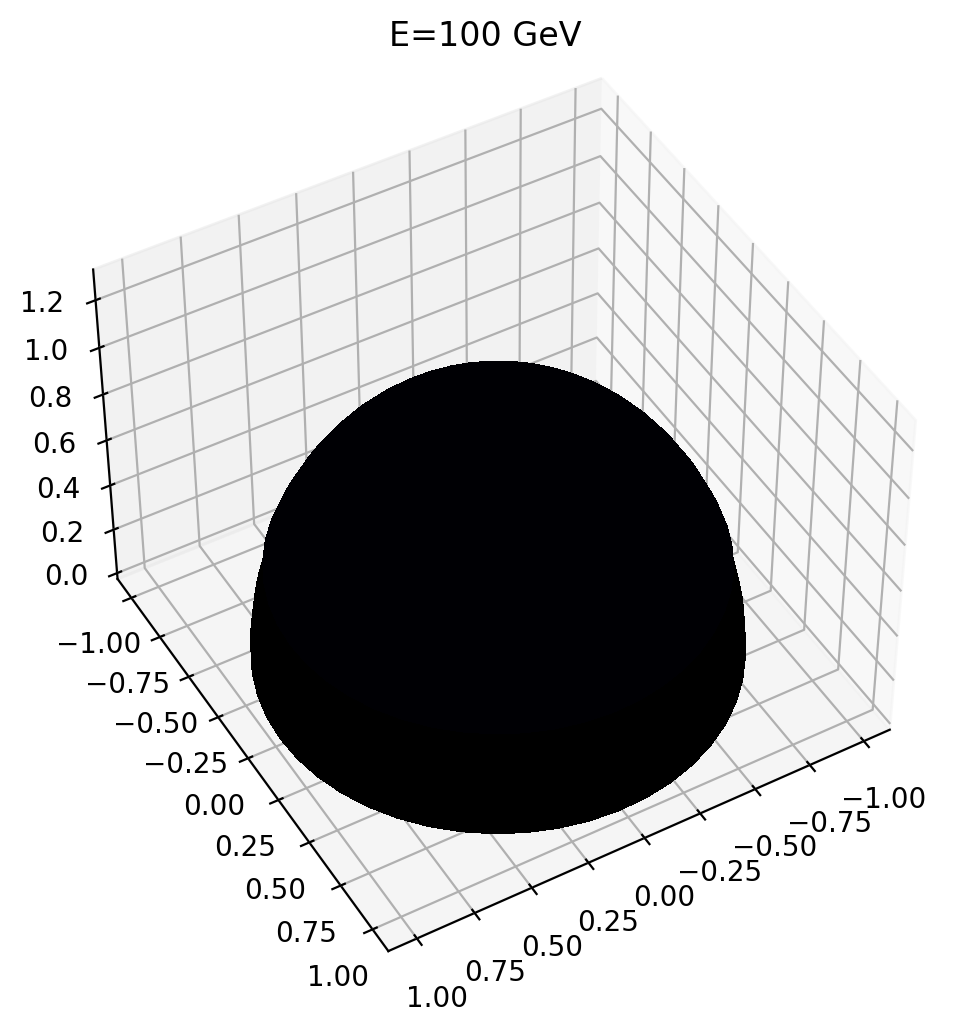

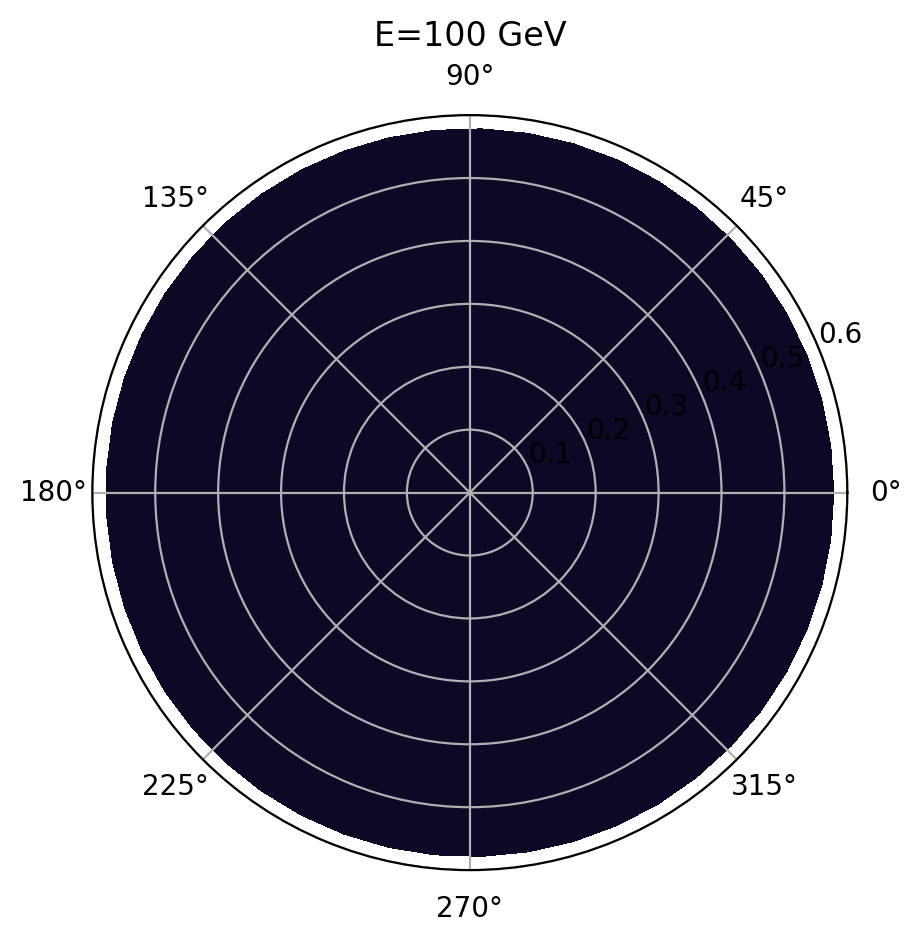

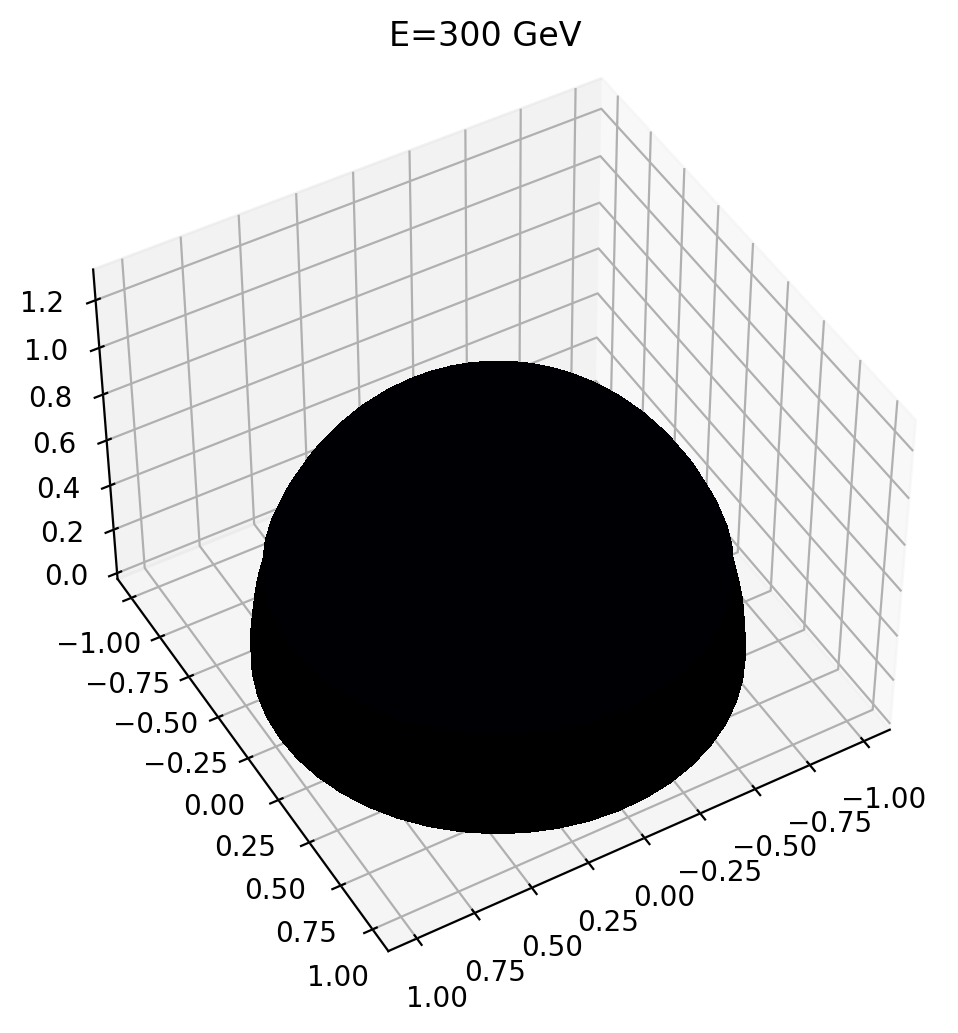

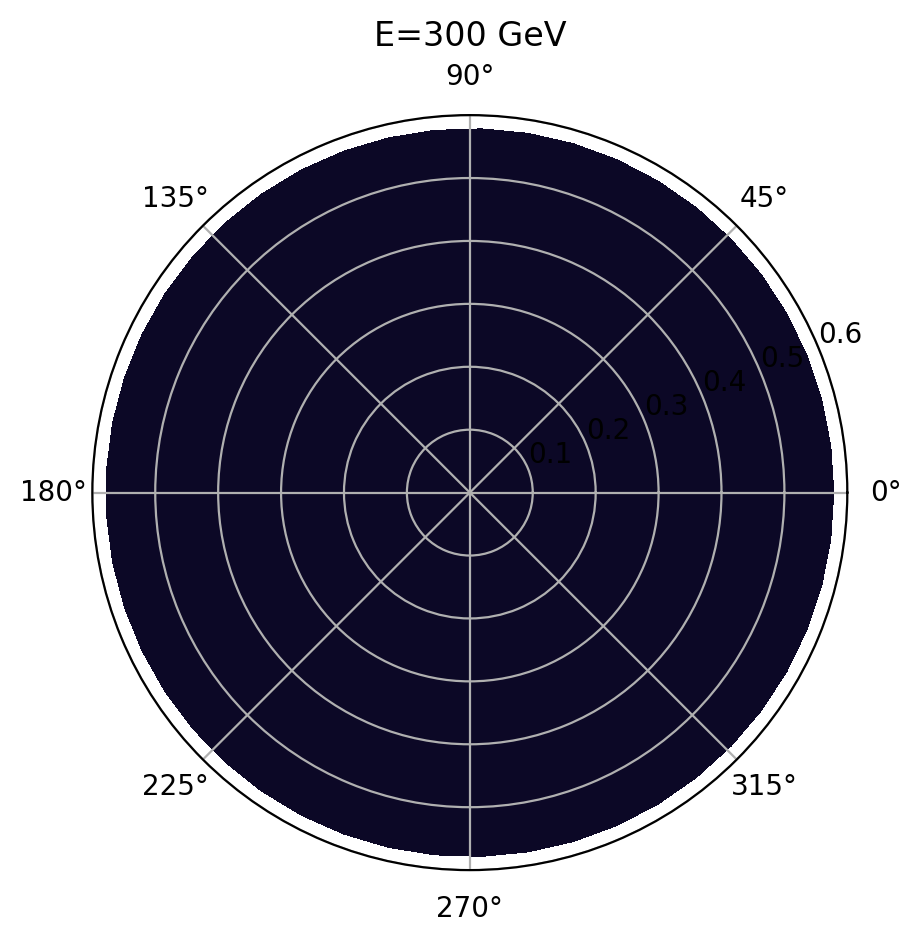

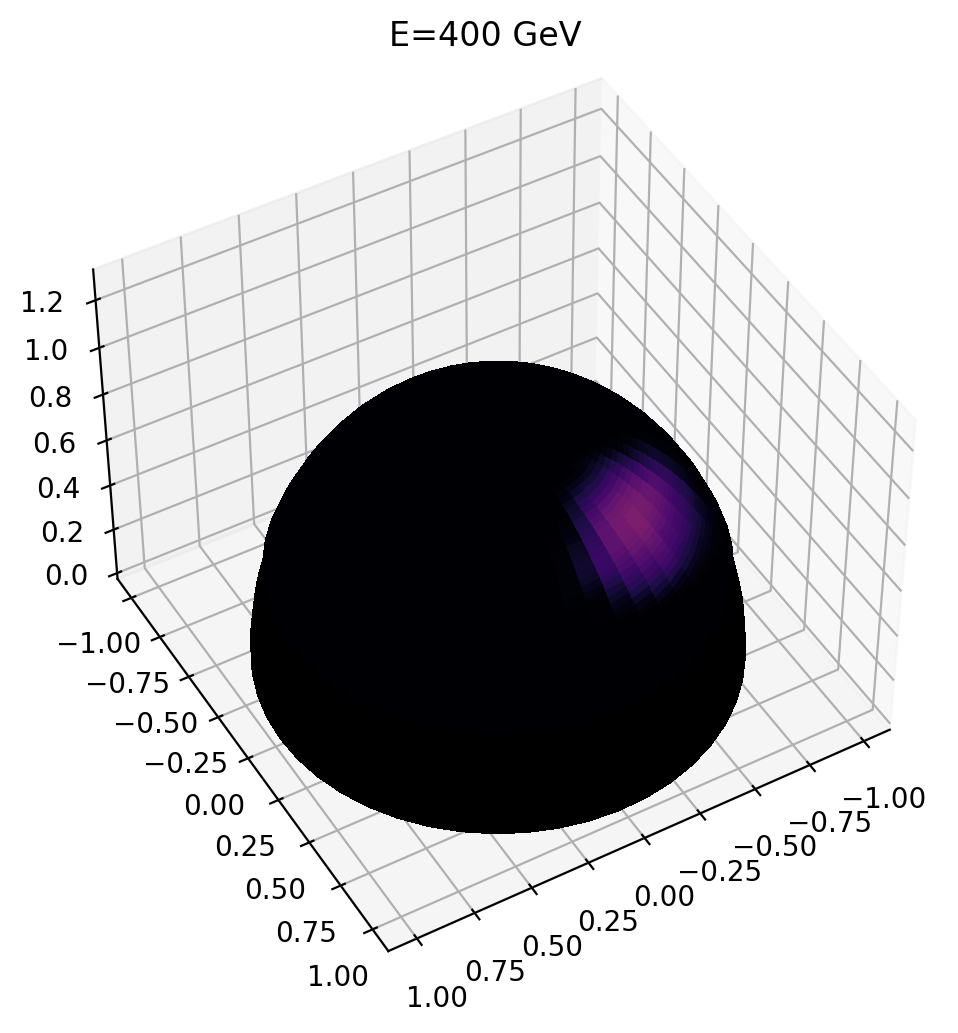

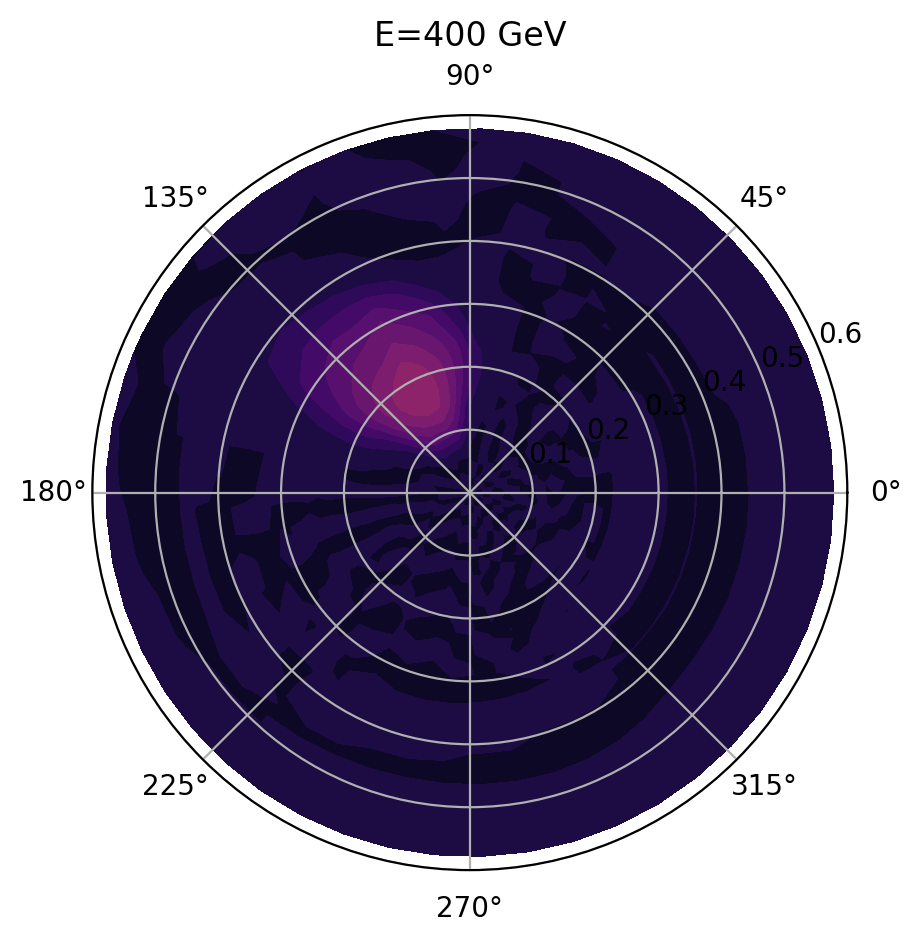

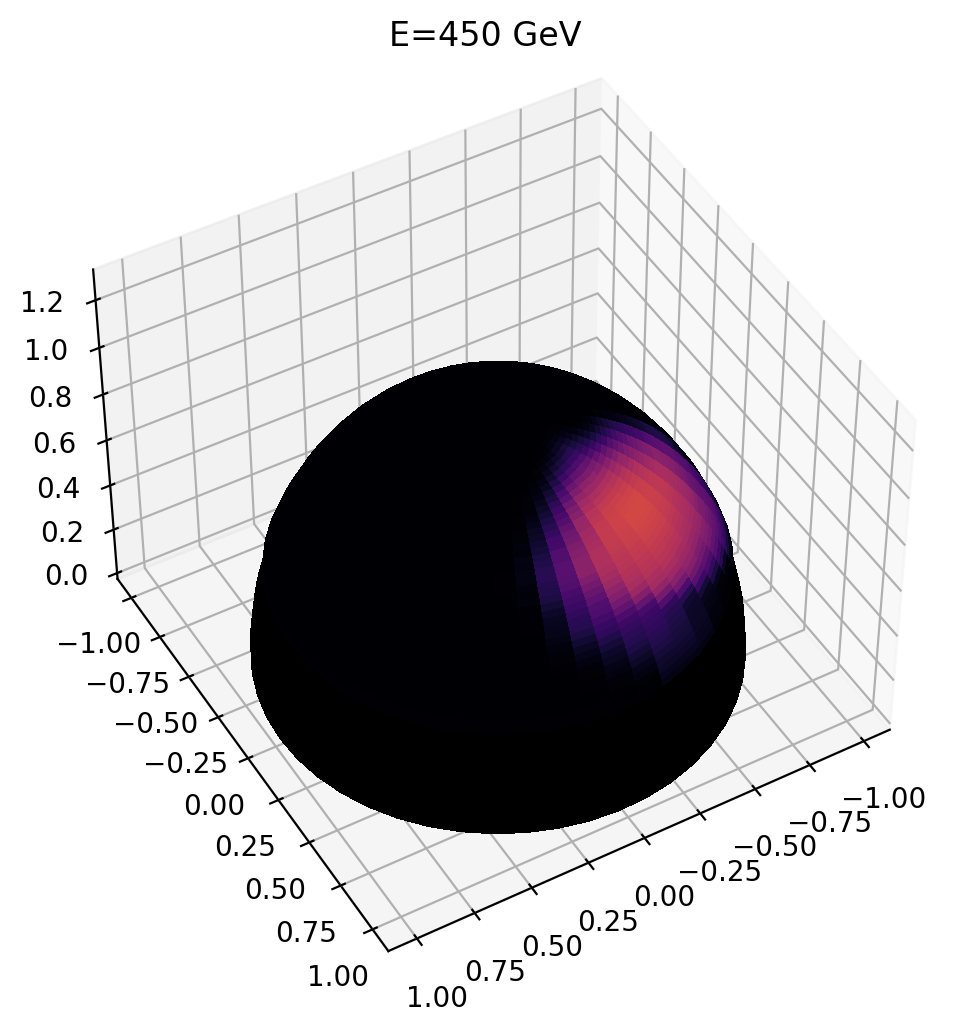

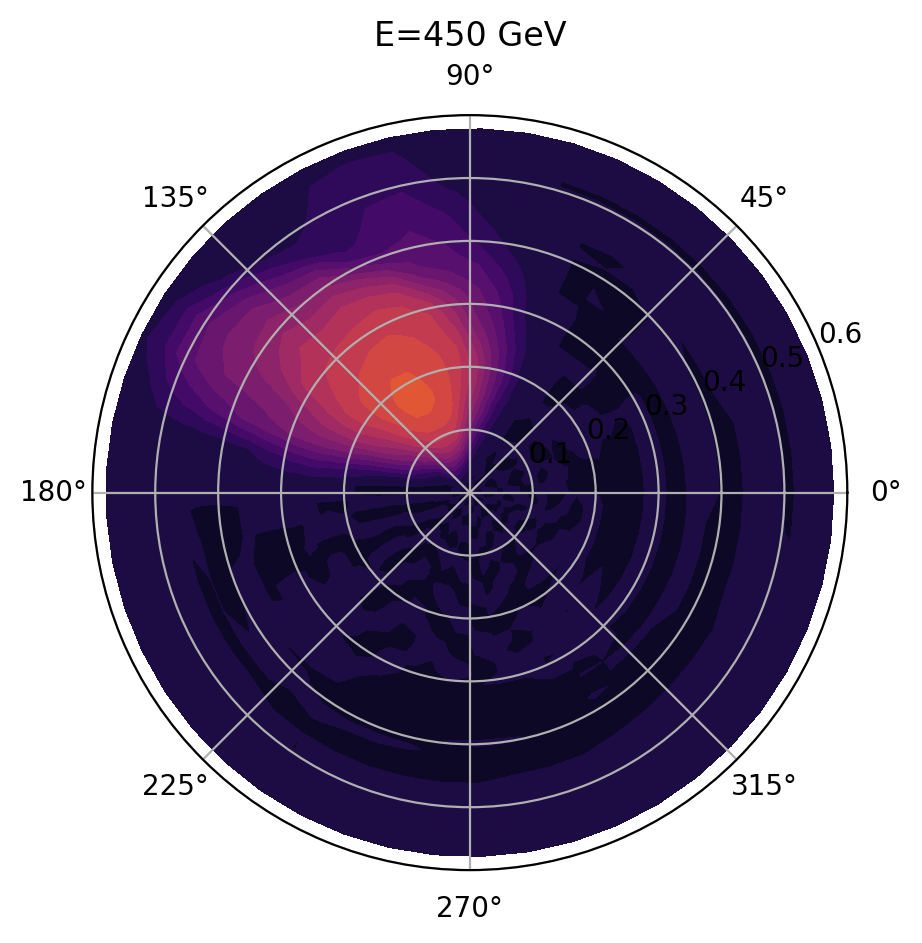

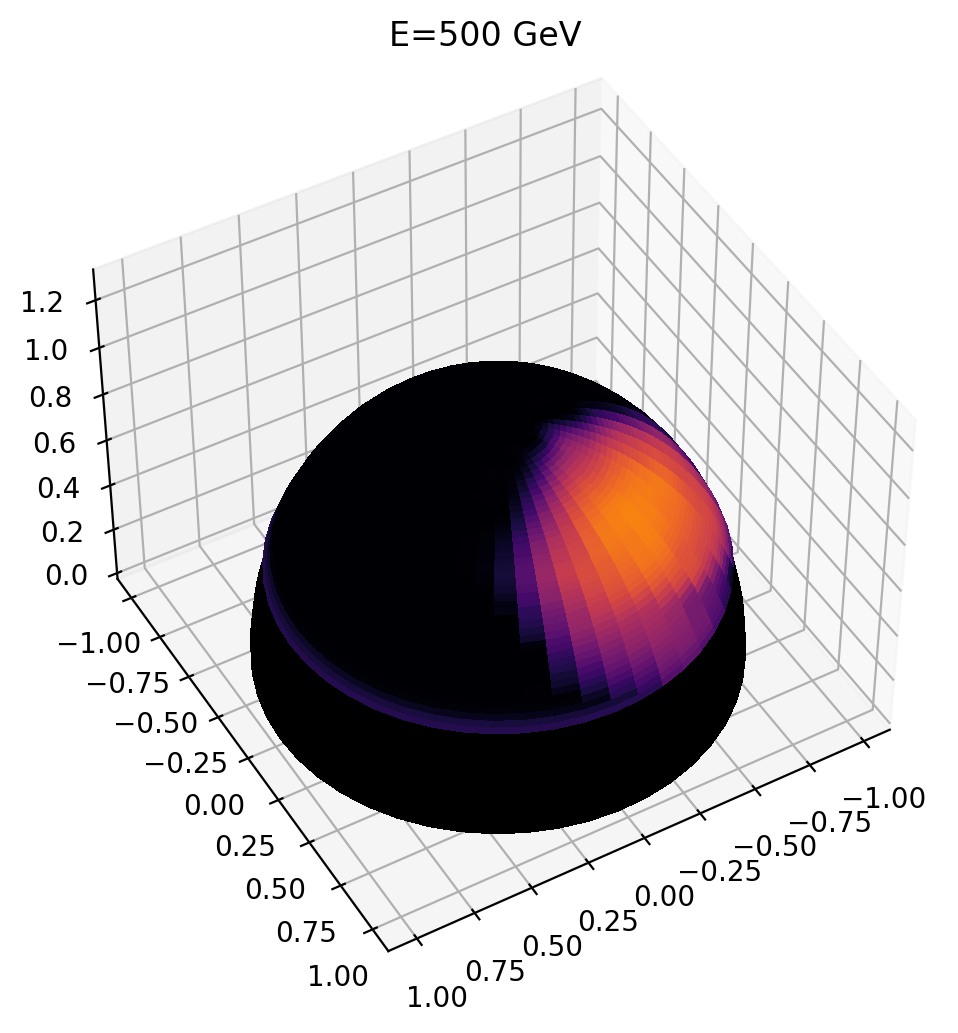

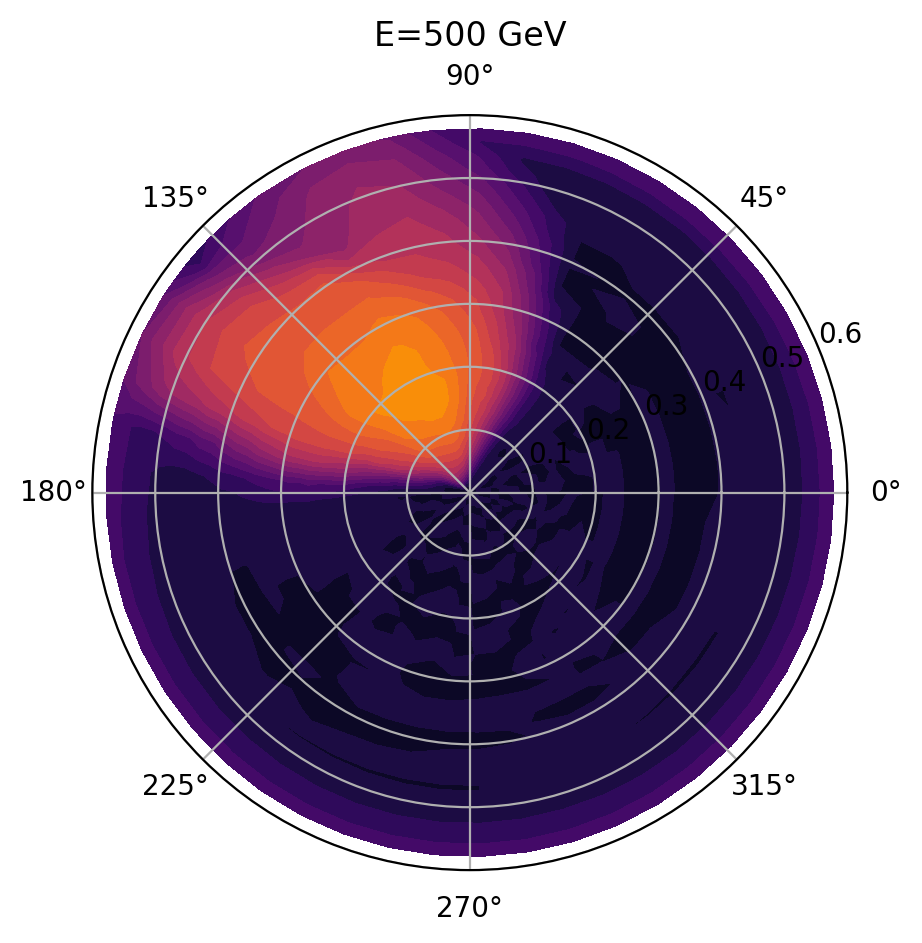

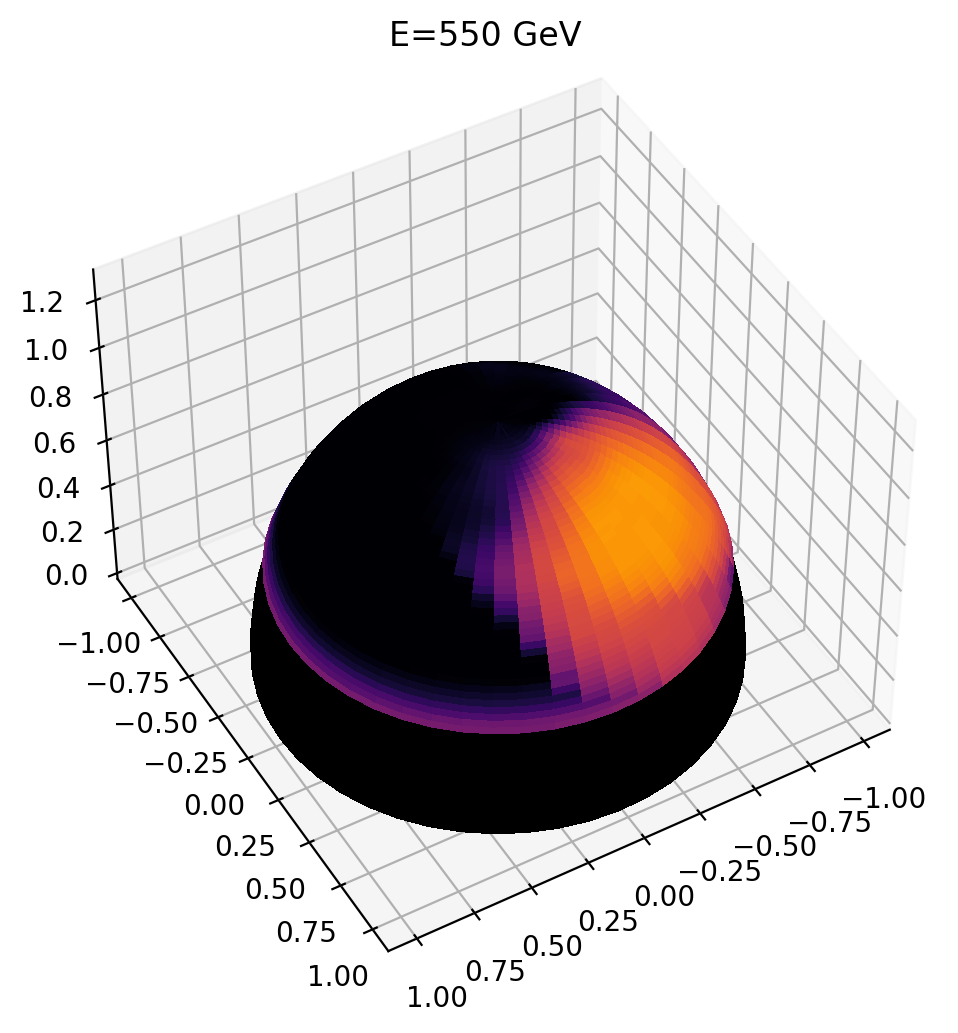

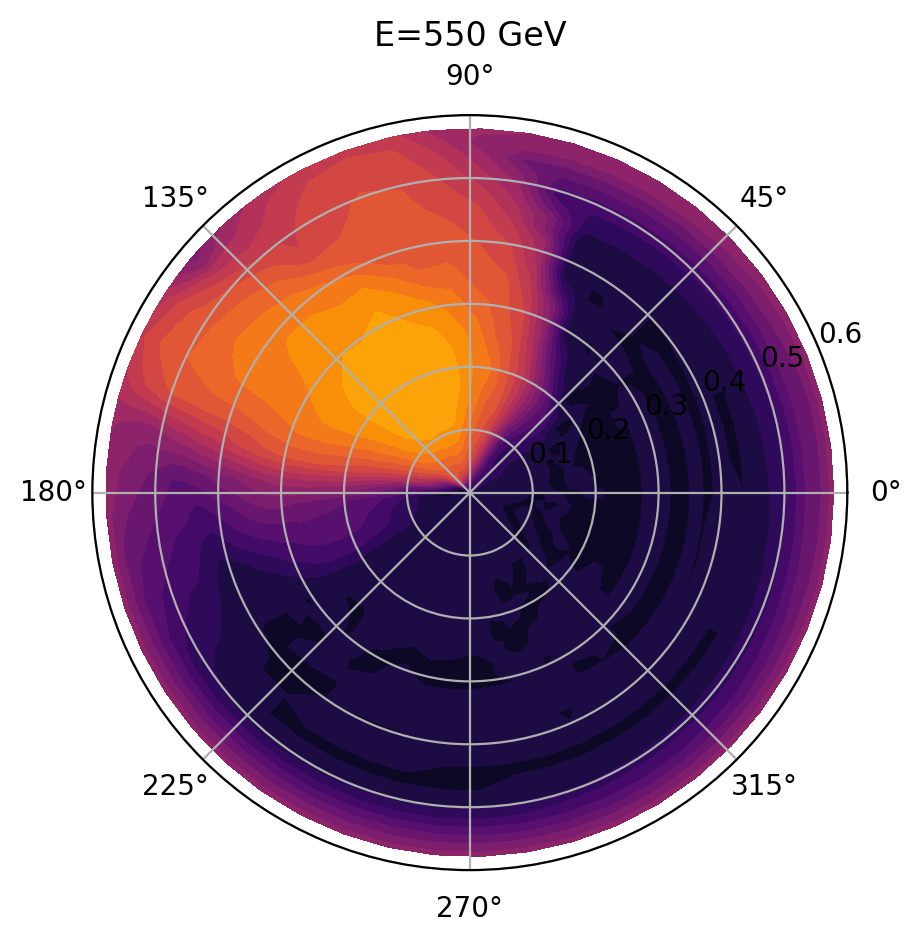

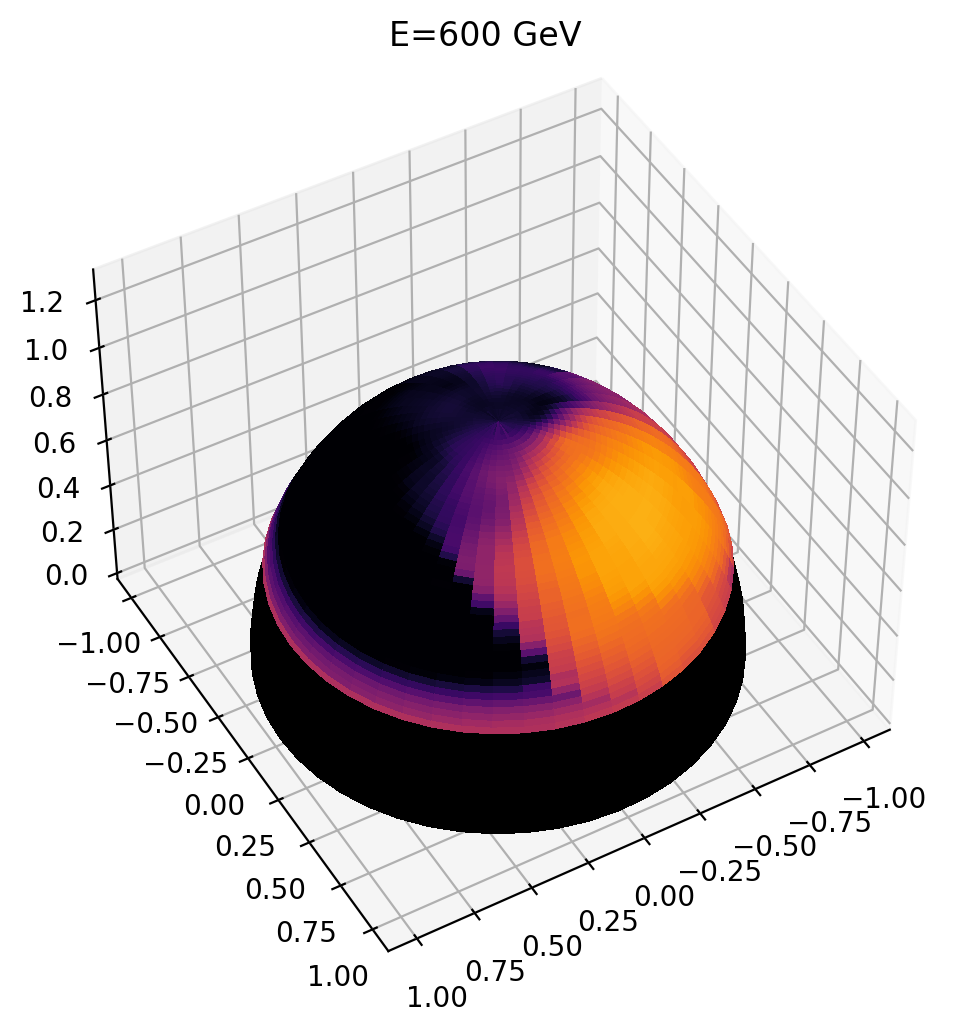

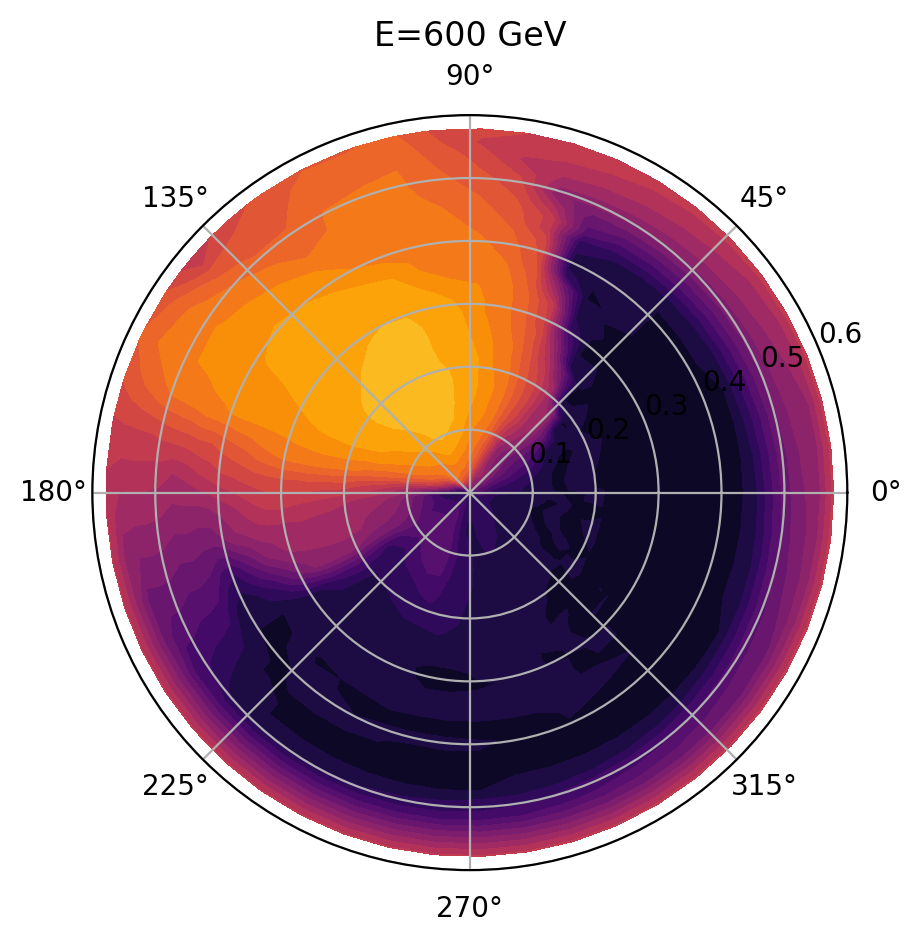

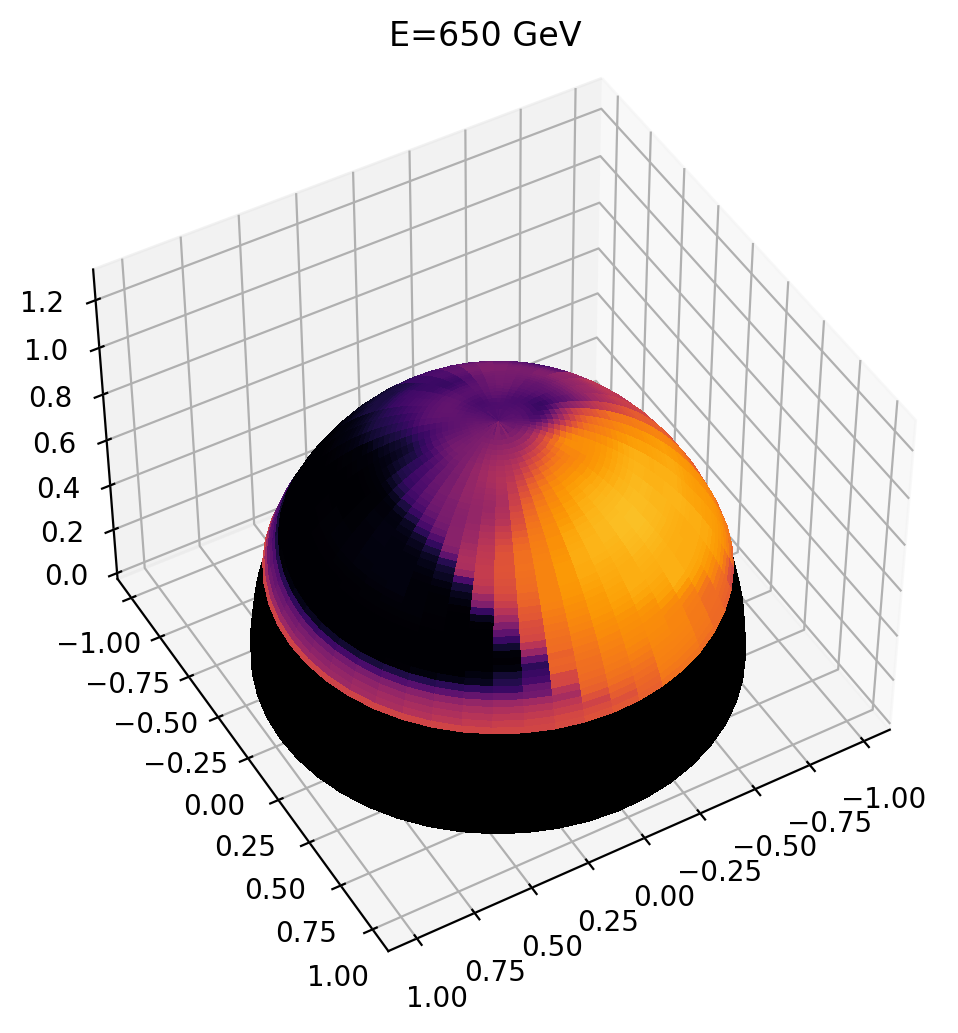

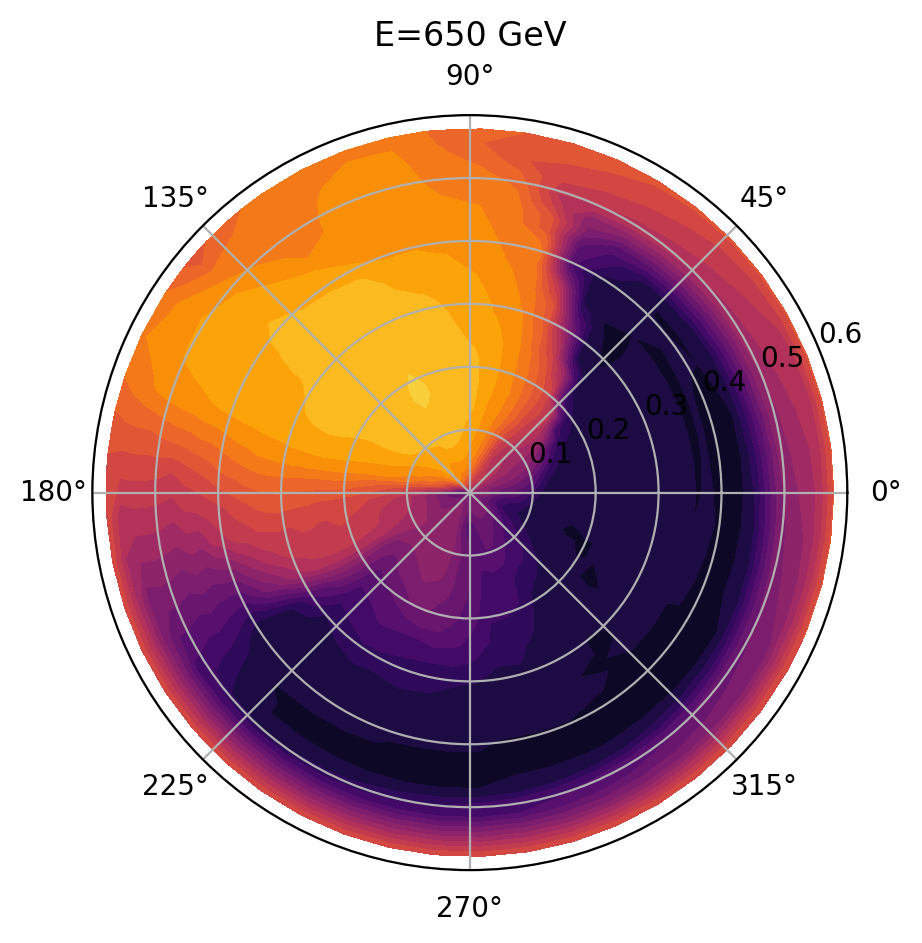

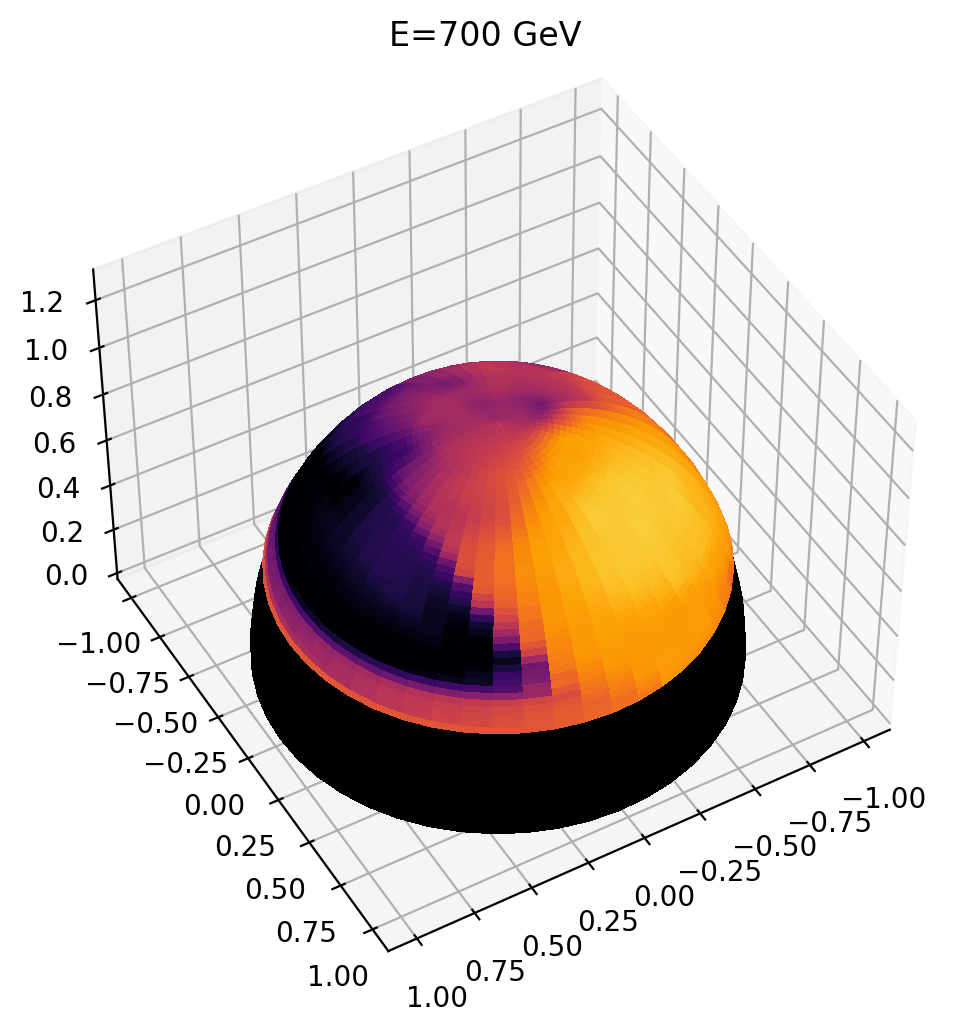

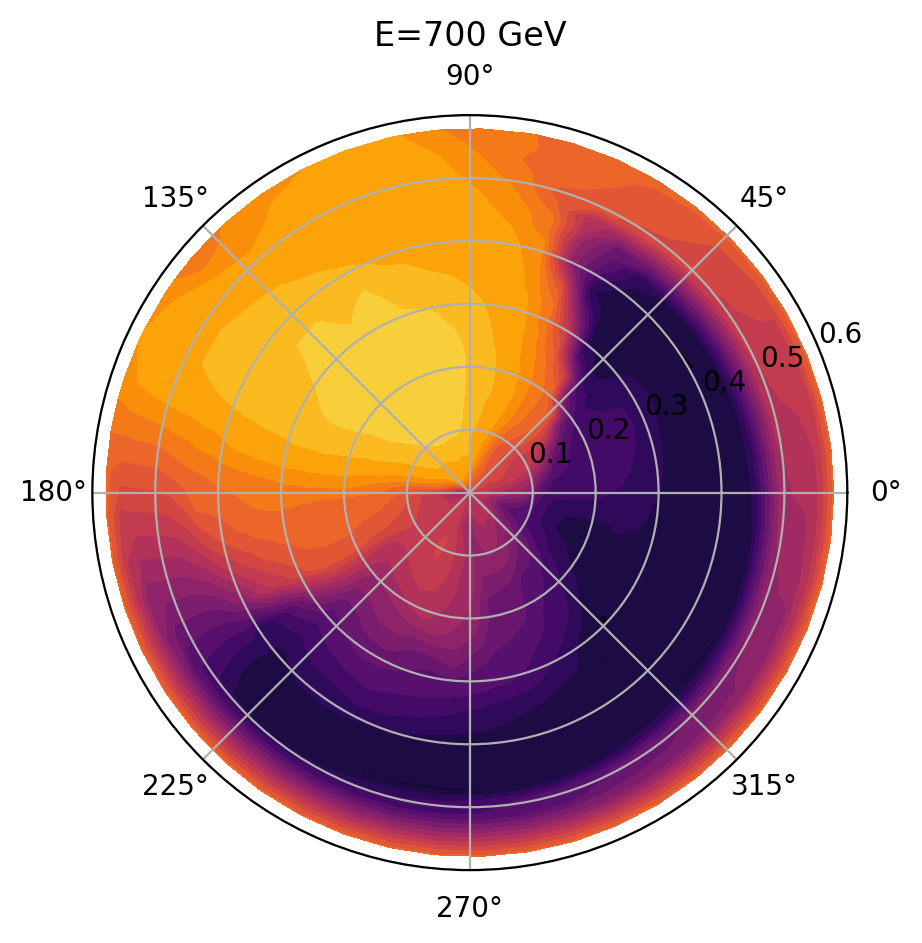

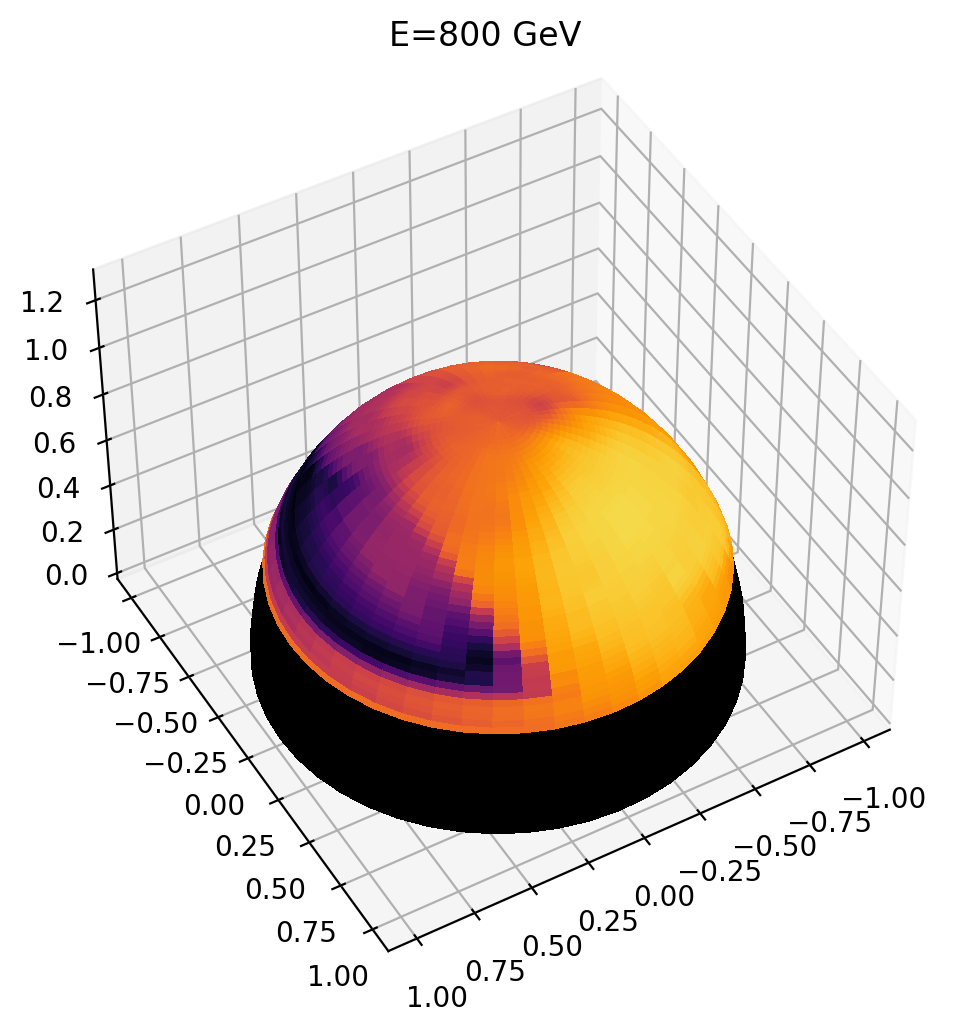

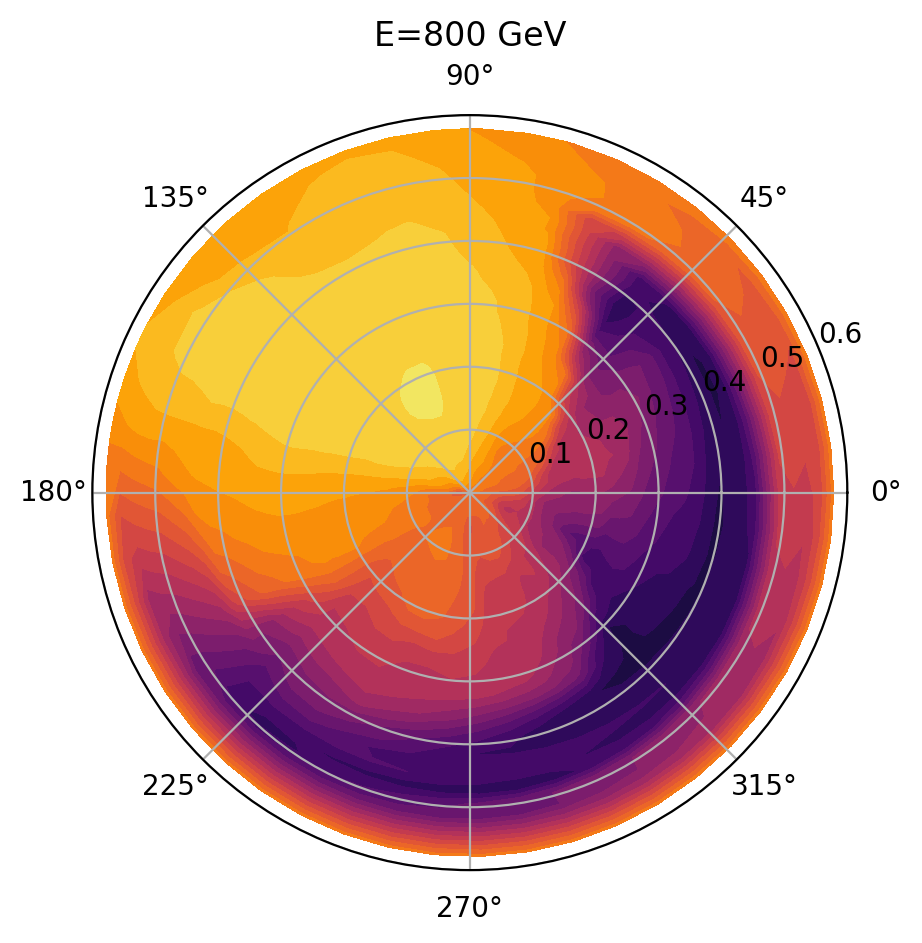

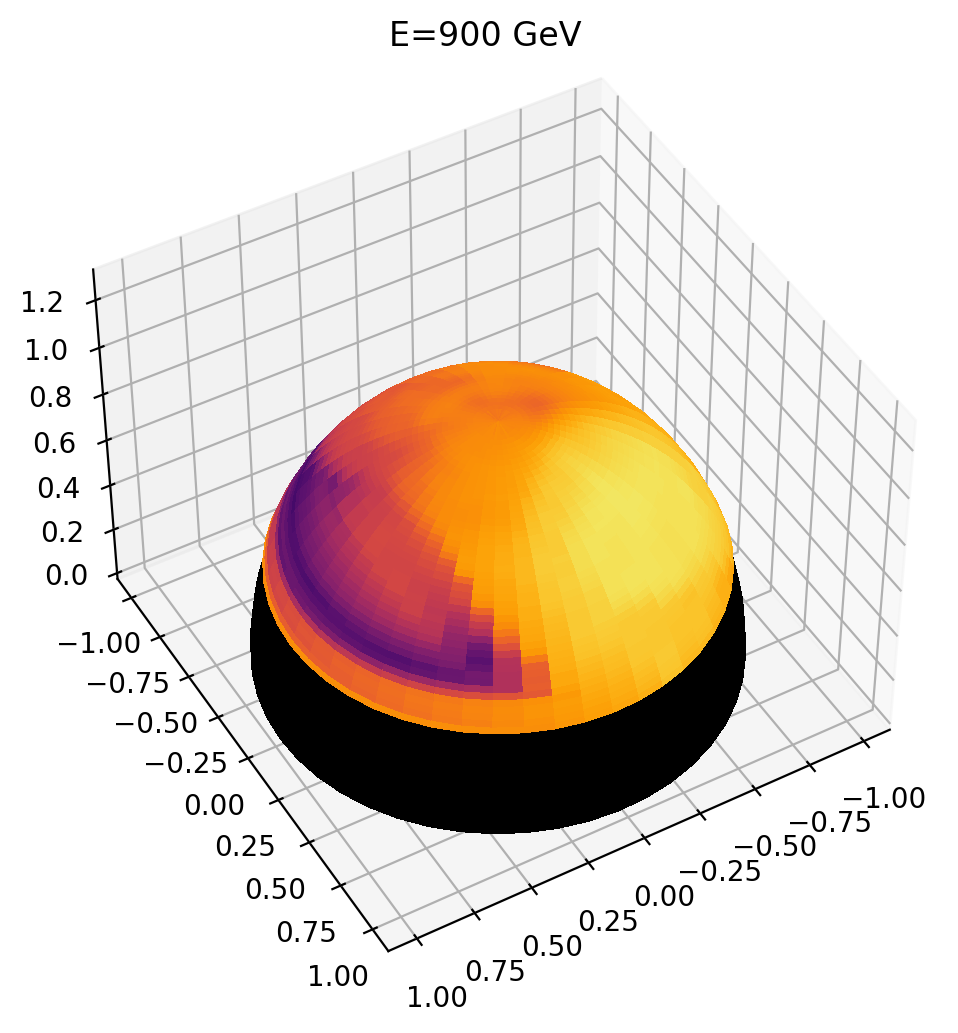

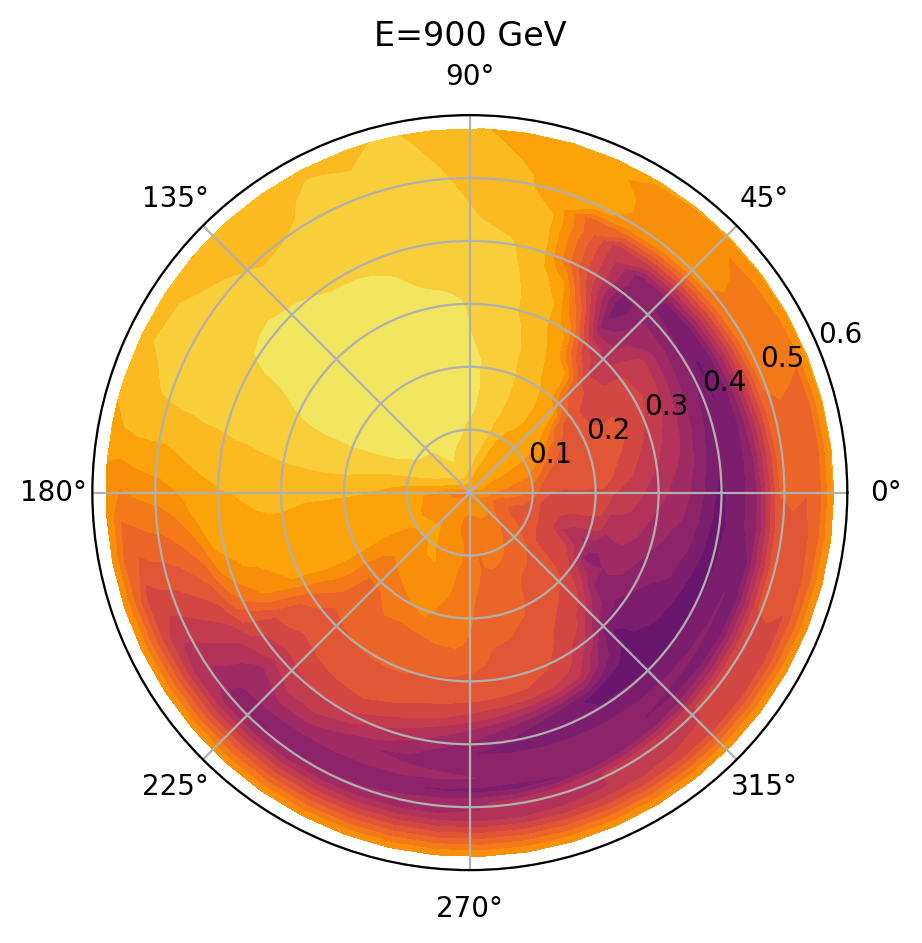

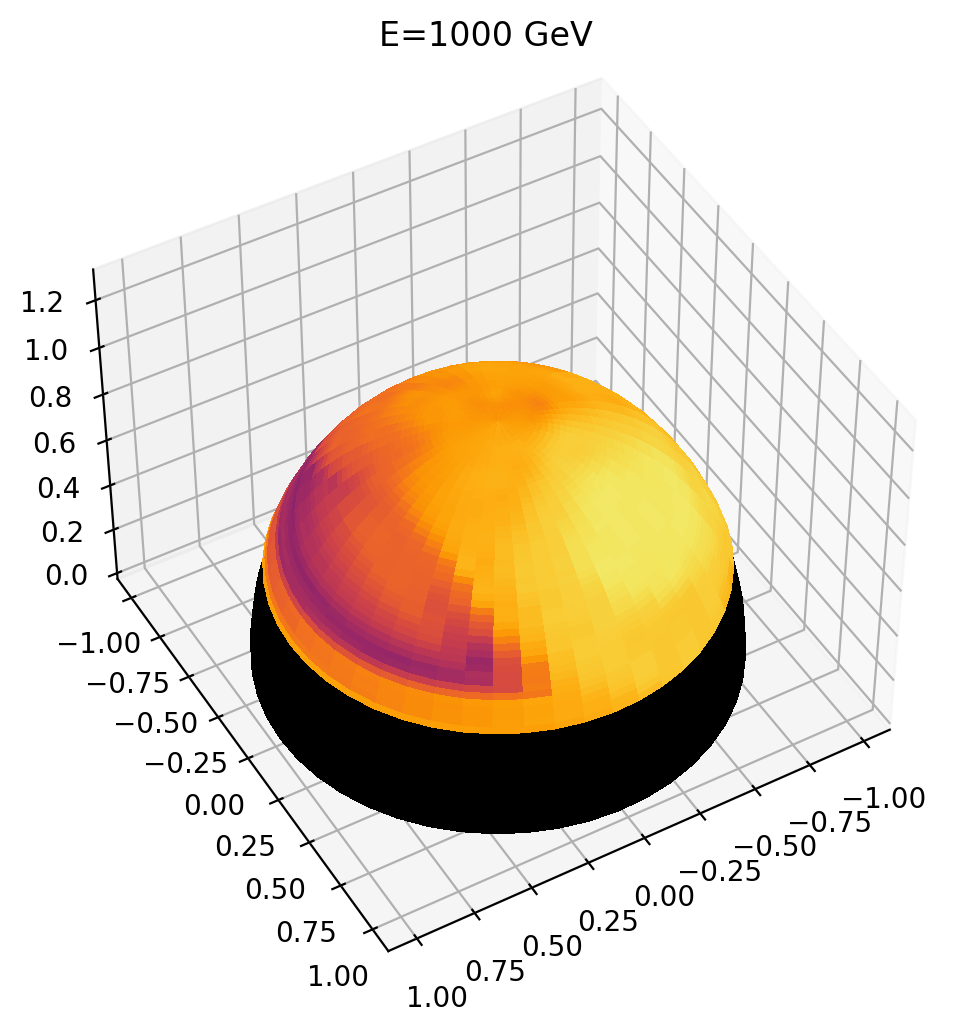

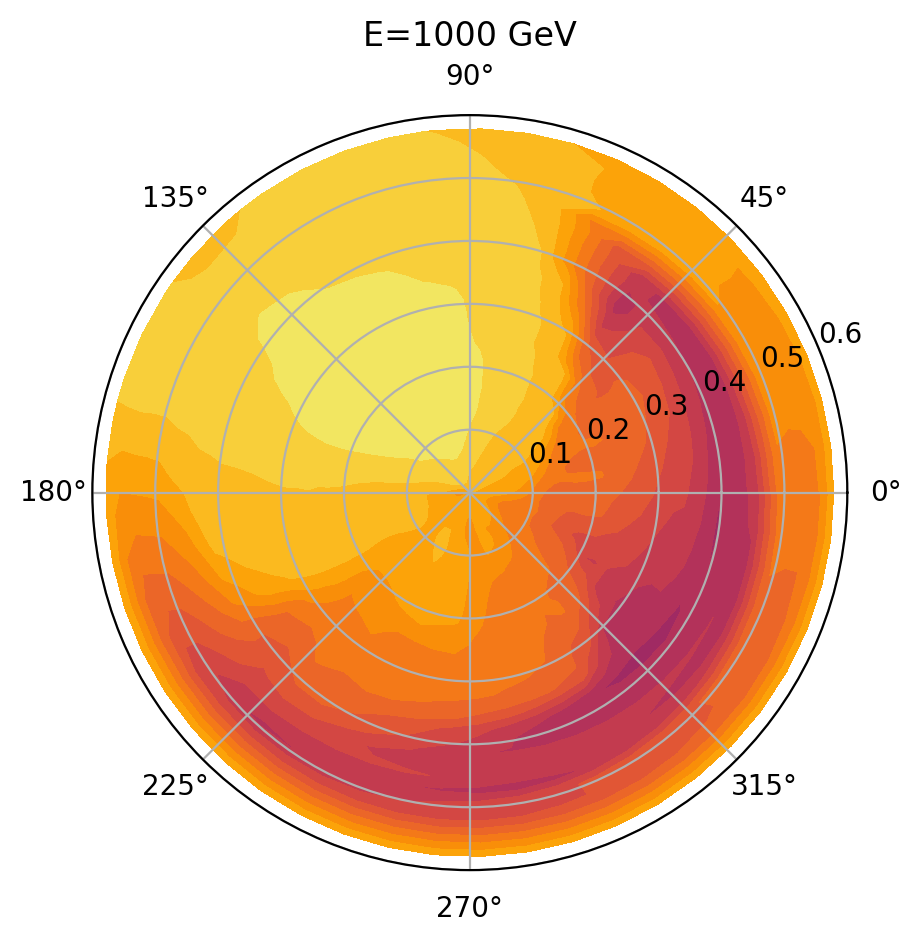

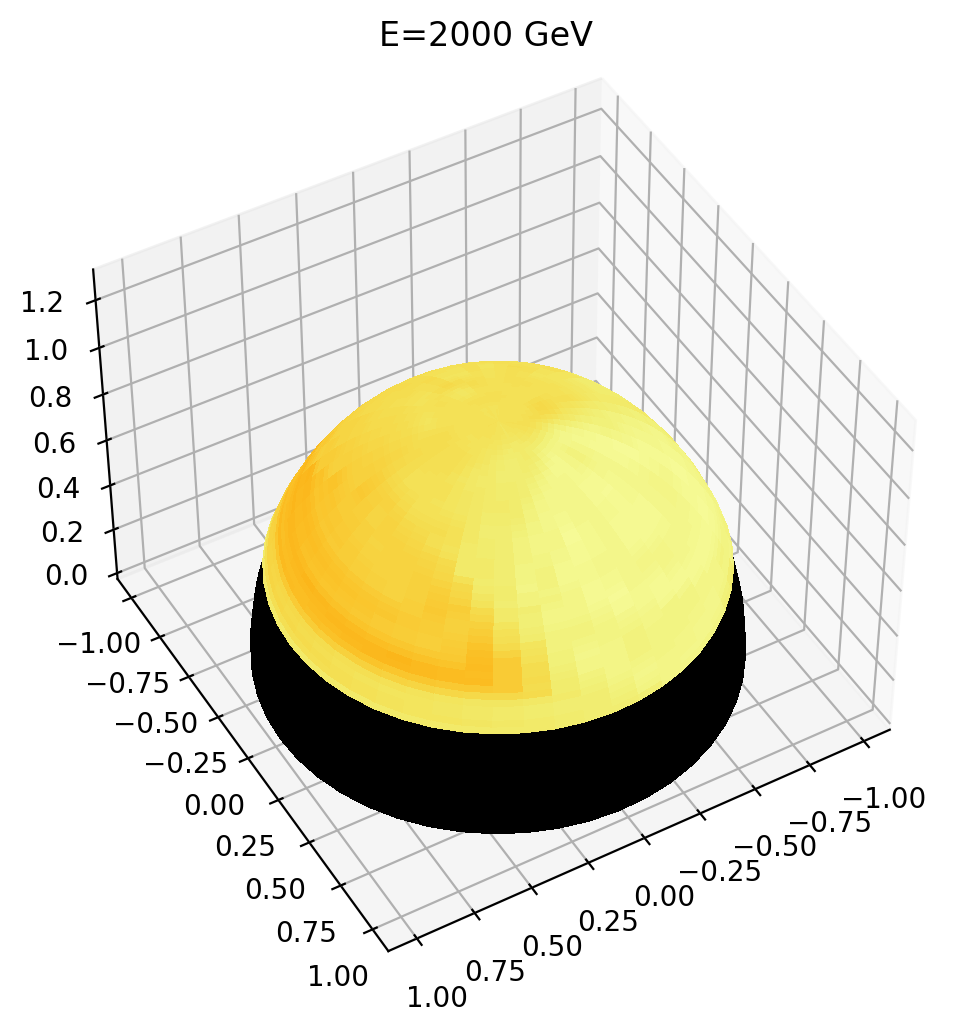

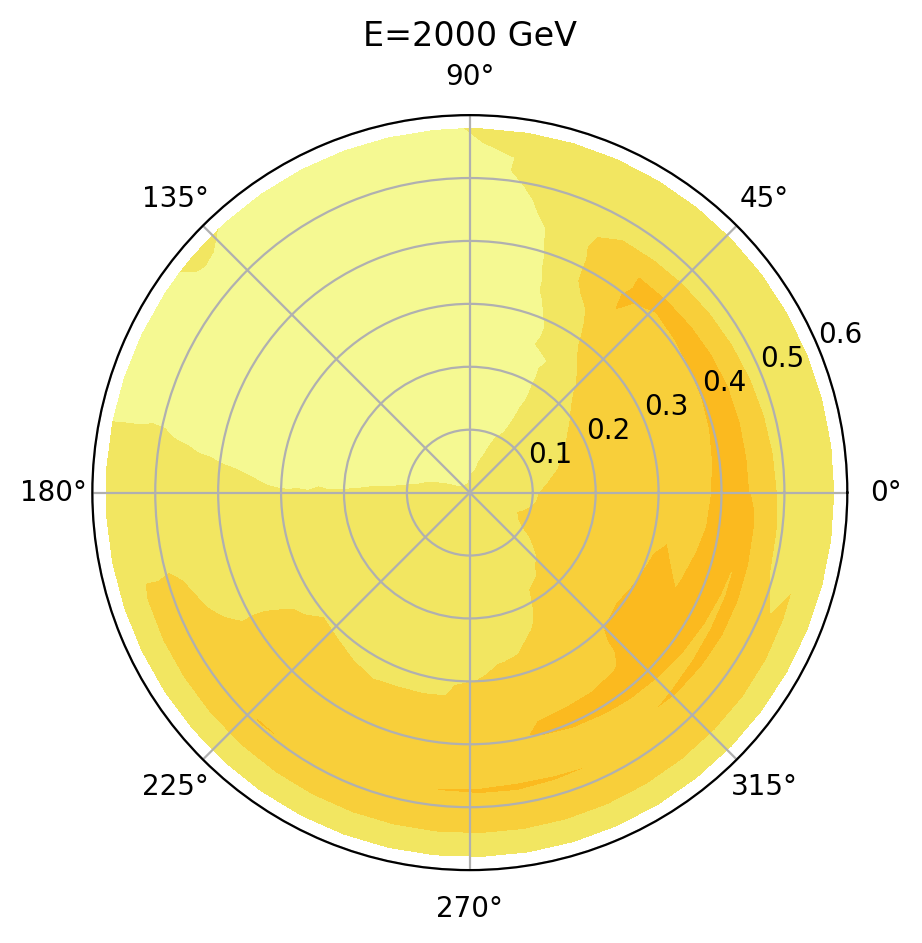

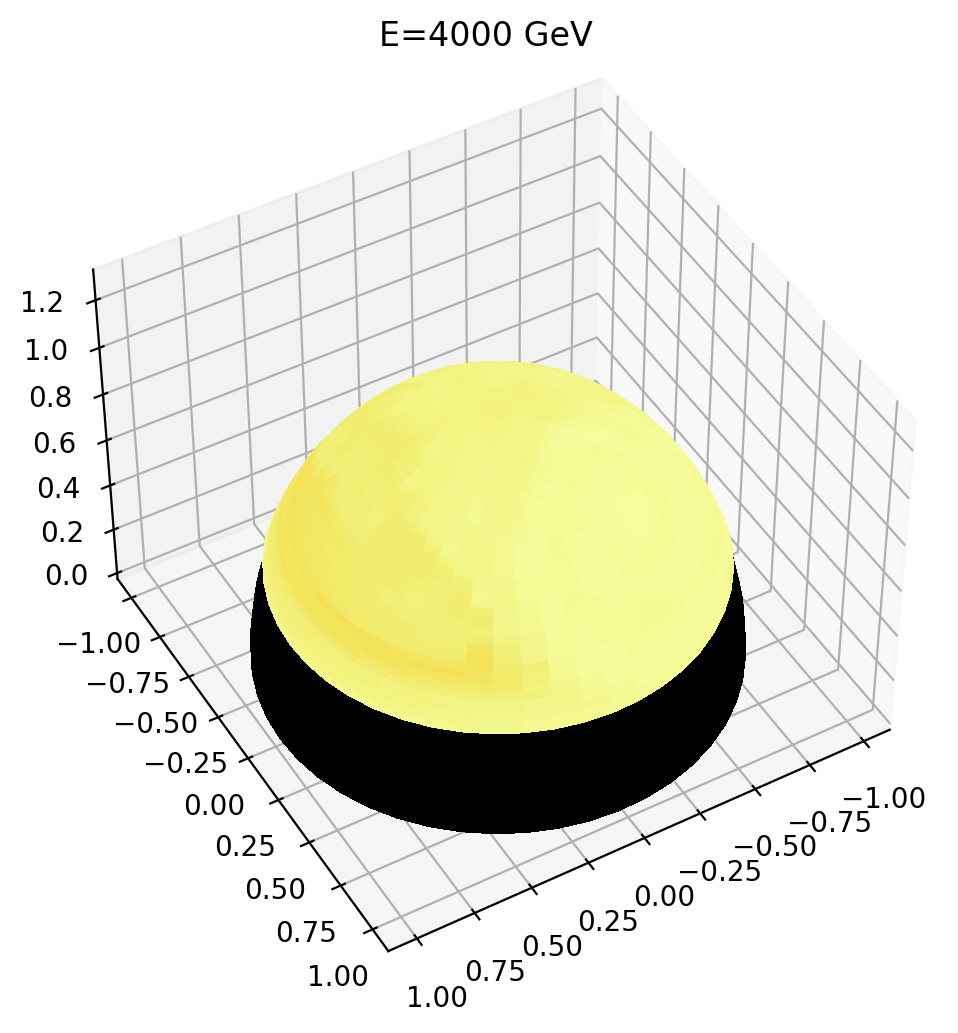

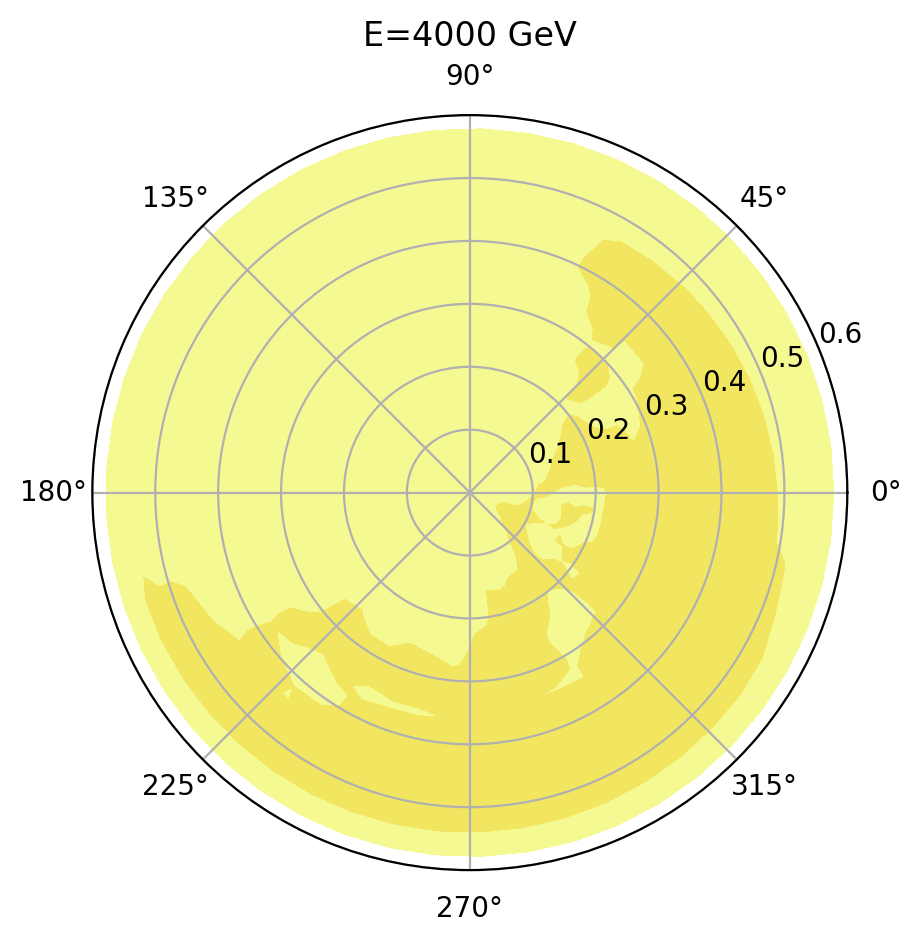

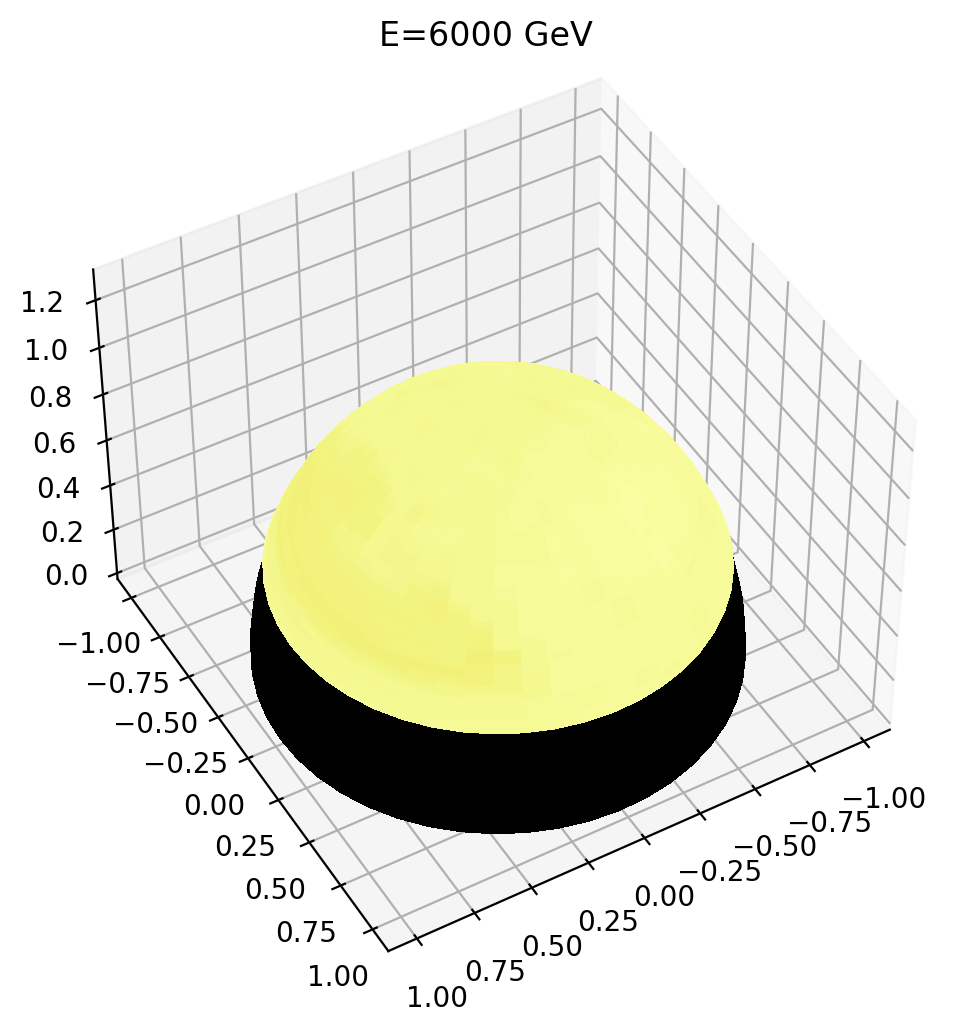

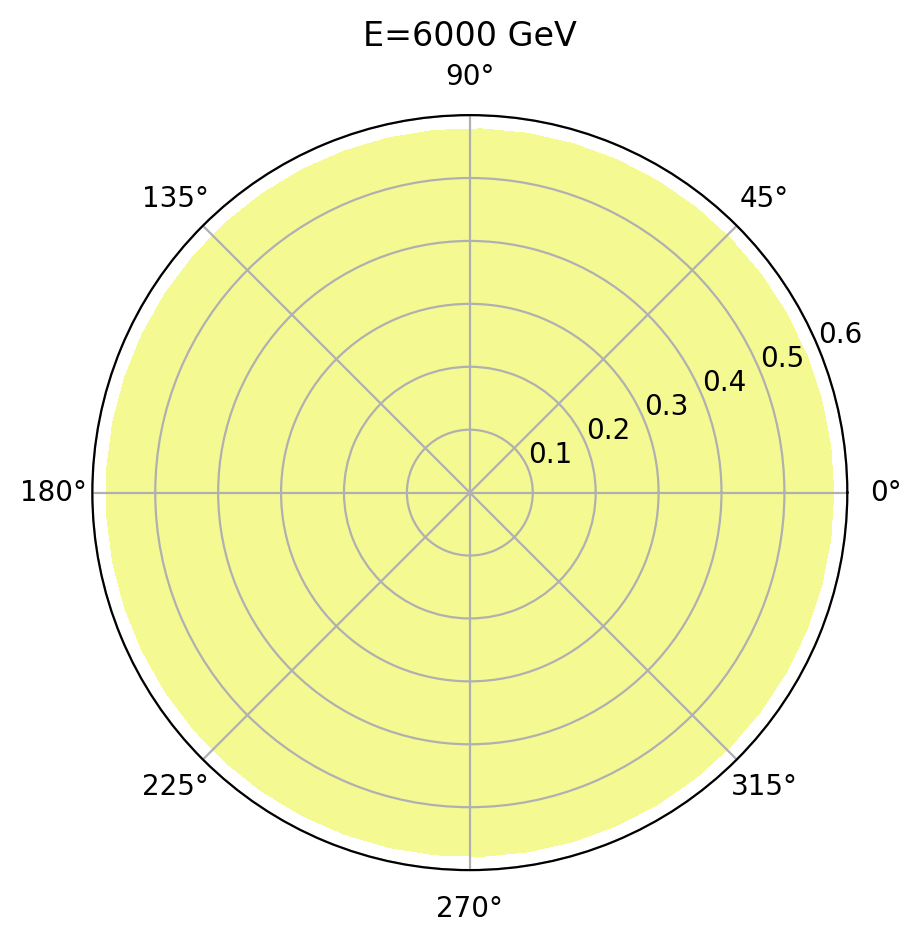

In [191]:
ei=0
LinInterps={}
NDInterps={}
for energy in energies:
    f= open('./InterpFunctions/Proposal_Muons_Interpolator'+str(energy)+'.0GeV.pkl', 'rb')
    PercentMuons = pickle.load(f)
    f.close()
    ei+=1
    intexs=[]
    inteys=[]
    intepercs=[]
    spacing=10
    NumToRun=1000
    Xmin=-600-spacing
    Xmax=600+spacing/2
    Ymin=-600-spacing
    Ymax=600+spacing/2
    for X in range(-600,600,spacing):
        for Y in range(-600,600,spacing):
            intexs.append(X)
            inteys.append(Y)
            intepercs.append(PercentMuons(X,Y)[0][0])
            
            
    intepercs = np.array(intepercs)
    intepercs=intepercs.reshape(len(np.unique(intexs)), len(np.unique(inteys)))

    costhetas=[]
    phis=[]
    survfrac=[]
    for i in range(0,len(intexs)):
        x=np.array(intexs).flatten()[i]
        y=np.array(inteys).flatten()[i]
        c=np.array(intepercs).flatten()[i]
        startMuon = (x,y)
        thMuon,phiMuon,depthMuon,distMuon=GetMuonInfo(startMuon)
        if(np.cos(thMuon)>0.4):
            survfrac.append(c)
            costhetas.append(np.cos(thMuon))
            phis.append(phiMuon)

    #Add shifted phis to satisfy periodic boundary condition
    costhetas=np.concatenate([costhetas,costhetas,costhetas,2-np.array(costhetas)])
    phis=np.concatenate([phis,np.array(phis)-2*np.pi,np.array(phis)+2*np.pi,phis])
    survfrac=np.concatenate([survfrac, survfrac, survfrac,survfrac])
    maxcol=max(np.array(survfrac).flatten())
    
    
    intereff_lin=LinearNDInterpolator(np.array([costhetas,phis]).transpose(),np.array(survfrac).flatten(),rescale=True)
    intereff_ND=NearestNDInterpolator(np.array([costhetas,phis]).transpose(),np.array(survfrac).flatten(),rescale=True)

    LinInterps[energy]=intereff_lin
    NDInterps[energy]=intereff_ND
    
    fig = plt.figure(figsize=(6,6),dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_facecolor('white')
    u, v = np.mgrid[0:np.arccos(0.4):50j, 0:2*np.pi:50j]
    allu, allv = np.mgrid[0:np.pi/2:50j, 0:2*np.pi:50j]




    strength = np.zeros_like(u)
    for i in range(0,len(u)):
        for j in range(0,len(v)):
            strength[i,j]=intereff_lin(np.cos(u[i,j]),v[i,j]-np.pi)
    norm=colors.Normalize(vmin = 0,
                          vmax = 1, clip = False)

    x = 1 * np.sin(u) * np.cos(v)
    y = 1 * np.sin(u) * np.sin(v)
    z = 1 * np.cos(u)


    allx = 0.98 * np.sin(allu) * np.cos(allv)
    ally = 0.98 * np.sin(allu) * np.sin(allv)
    allz = 0.98 * np.cos(allu)

    ax.plot_surface(allx, ally, allz, rstride=1, cstride=1, cmap=cm.inferno,
                           linewidth=0, antialiased=False,
                           facecolors=cm.afmhot(np.zeros_like(norm(strength))))

    ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.inferno, vmin=0, vmax=1,
                           linewidth=0, antialiased=False,
                           facecolors=cm.inferno(norm(strength)))
    plt.title("E="+str(energy)+" GeV")
    ax.view_init(elev=45, azim=60)
    ax.set_zlim(0,1.3)


    plt.savefig("MushroomsLin/"+str(ei).zfill(2)+".png",dpi=200)
    plt.show()
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'),figsize=(5,5),dpi=200)
    fig.patch.set_facecolor('white')


    levels=np.arange(-0.1,1.01,0.05)
    ax.contourf(v,1.-np.cos(u), norm(strength),cmap='inferno',levels=levels)
    plt.title("E="+str(energy)+" GeV")
    plt.savefig("Radars/"+str(ei).zfill(2)+".png",dpi=200)
    plt.show()

    

In [108]:
levels

array([-0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
        0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,
        0.8 ,  0.85,  0.9 ,  0.95,  1.  ])

In [192]:
f=open("LinInterps.pkl",'wb')
pickle.dump(LinInterps,f)
f.close()
f=open("NDInterps.pkl",'wb')
pickle.dump(NDInterps,f)
f.close()

NameError: name 'values' is not defined

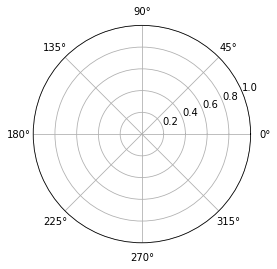

In [97]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, values)

plt.show()